In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [52]:
costs = {
    "capex": {
        "2018": {
            "contactor": 111.48,
            "fan": 6.48,
            "vacuum_pump": 5.08,
            "heat_exchanger": 1.97
        }
    },
    "opex": {
        "2018": {
            "fan": 16.26,
            "vacuum_pump": 12.19,
            "compression": 6.63,
            "maintenance": 23.96,
            "labor": 7.27,
            "steam": 22.68,
            "storage": 11.0
        }
    }
}

compression_capex = 6.00
trucking_capex = 9.01 - compression_capex

costs["capex"]["2018"]["compression"] = compression_capex
costs["capex"]["2018"]["trucking"] = trucking_capex

In [53]:
contactor_improvement_rate = 0.033097

contactor_capex_2030 = costs["capex"]["2018"]["contactor"] * (1 - contactor_improvement_rate) ** (2030 - 2018)
print(contactor_capex_2030)

costs["capex"]["2030"] = {
    "contactor": contactor_capex_2030,
    "fan": costs["capex"]["2018"]["fan"],
    "vacuum_pump": costs["capex"]["2018"]["vacuum_pump"],
    "heat_exchanger": costs["capex"]["2018"]["heat_exchanger"],
    "compression": costs["capex"]["2018"]["compression"],
    "trucking": costs["capex"]["2018"]["trucking"]
}

74.43751264849749


In [54]:
thermal_requirement_2030 = (2.03 + 3.4) / 2
steam_price = 2.9

steam_opex_2030 = thermal_requirement_2030 * steam_price
print(steam_opex_2030)

# sum 2018 capex
capex_2018 = sum(costs["capex"]["2018"].values())
print(capex_2018)
mtc_fraction = costs["opex"]["2018"]["maintenance"] / capex_2018
mtc_opex_2030 = mtc_fraction * sum(costs["capex"]["2030"].values())
labor_fraction = costs["opex"]["2018"]["labor"] / capex_2018
labor_opex_2030 = labor_fraction * sum(costs["capex"]["2030"].values())

storage_improvement_rate = 0.013336
storage_opex_2030 = costs["opex"]["2018"]["storage"] * (1 - storage_improvement_rate) ** (2030 - 2018)

costs["opex"]["2030"] = {
    "fan": costs["opex"]["2018"]["fan"],
    "vacuum_pump": costs["opex"]["2018"]["vacuum_pump"],
    "compression": costs["opex"]["2018"]["compression"],
    "maintenance": mtc_opex_2030,
    "labor": labor_opex_2030,
    "steam": steam_opex_2030,
    "storage": storage_opex_2030
}

costs


7.873499999999999
134.01999999999998


{'capex': {'2018': {'contactor': 111.48,
   'fan': 6.48,
   'vacuum_pump': 5.08,
   'heat_exchanger': 1.97,
   'compression': 6.0,
   'trucking': 3.01},
  '2030': {'contactor': 74.43751264849749,
   'fan': 6.48,
   'vacuum_pump': 5.08,
   'heat_exchanger': 1.97,
   'compression': 6.0,
   'trucking': 3.01}},
 'opex': {'2018': {'fan': 16.26,
   'vacuum_pump': 12.19,
   'compression': 6.63,
   'maintenance': 23.96,
   'labor': 7.27,
   'steam': 22.68,
   'storage': 11.0},
  '2030': {'fan': 16.26,
   'vacuum_pump': 12.19,
   'compression': 6.63,
   'maintenance': 17.337570534681394,
   'labor': 5.260606752384546,
   'steam': 7.873499999999999,
   'storage': 9.36319516796092}}}

In [55]:
total_cost_2018 = sum(costs["capex"]["2018"].values()) + sum(costs["opex"]["2018"].values())
print(total_cost_2018)
total_cost_2030 = sum(costs["capex"]["2030"].values()) + sum(costs["opex"]["2030"].values())
total_cost_2030

234.01


171.89238510352436

In [56]:
grid_intensities = {
    2014: 1232.35,
    2015: 1136.53,
    2018: 998.4,
    2020: 947.2,
    2021: 884.2,
    2022: 818.3,
    2023: 852.3,
    2024: 823.1
}

grid_intensities_df = pd.DataFrame(list(grid_intensities.items()), columns=["year", "grid_intensity_lb_per_MWh"])
grid_intensities_df

,year,grid_intensity_lb_per_MWh
0,2014,1232.35
1,2015,1136.53
2,2018,998.40
3,2020,947.20
4,2021,884.20
5,2022,818.30
6,2023,852.30
7,2024,823.10


In [57]:
grid_intensities_df["grid_intensity_g_per_kWh"] = grid_intensities_df["grid_intensity_lb_per_MWh"] * 453.592 / 1000
grid_intensities_df

,year,grid_intensity_lb_per_MWh,grid_intensity_g_per_kWh
0,2014,1232.35,558.984101
1,2015,1136.53,515.520916
2,2018,998.40,452.866253
3,2020,947.20,429.642342
4,2021,884.20,401.066046
5,2022,818.30,371.174334
6,2023,852.30,386.596462
7,2024,823.10,373.351575


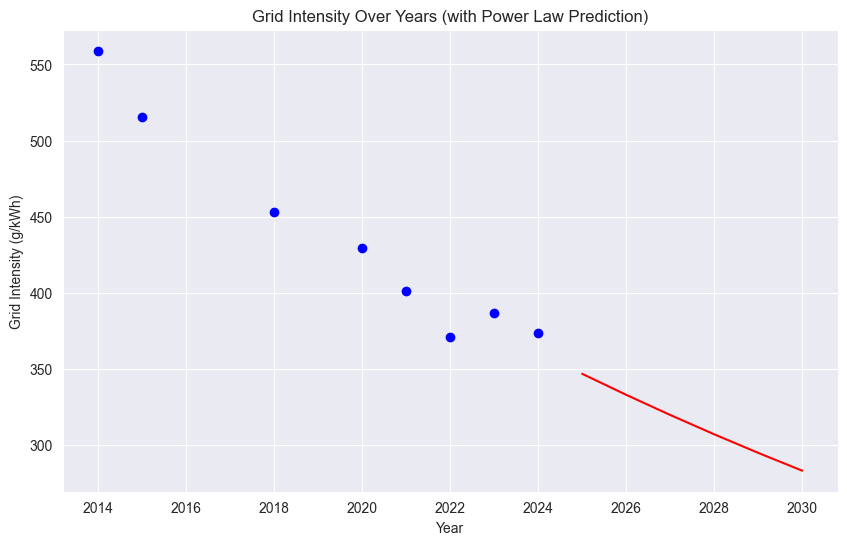

In [58]:
X_log = np.log(grid_intensities_df['year'])
y_log = np.log(grid_intensities_df['grid_intensity_g_per_kWh'])

# Fit a linear regression model
model = LinearRegression()
model.fit(X_log.values.reshape(-1, 1), y_log.values)

# Predict for future years
future_years = np.array([2025, 2026, 2027, 2028, 2029, 2030])
log_predictions = model.predict(np.log(future_years).reshape(-1, 1))

# Transform predictions back to the original scale
predictions = np.exp(log_predictions)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(grid_intensities_df['year'], grid_intensities_df['grid_intensity_g_per_kWh'], color='blue')
plt.plot(future_years, predictions, color='red')
plt.title('Grid Intensity Over Years (with Power Law Prediction)')
plt.xlabel('Year')
plt.ylabel('Grid Intensity (g/kWh)')
plt.grid(True)
plt.show()

In [59]:
recent_grid_intensities_df = grid_intensities_df[grid_intensities_df['year'] >= 2020]

X = recent_grid_intensities_df['year'].values.reshape(-1, 1)
y = recent_grid_intensities_df['grid_intensity_g_per_kWh'].values

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict the value for 2030
pred_2030_grid_intensity = model.predict(np.array([[2030]]))[0]
pred_2030_grid_intensity # g/kWh

290.7252564800001

In [60]:
power_2030_grid_intensity = predictions[-1]
power_2030_grid_intensity

283.2464359801988

In [61]:
electrical_requirement = 1.5 # GJ/ton
gj_to_kwh = 277.778
electrical_requirement_kwh = electrical_requirement * gj_to_kwh

electric_co2_footprint_g = pred_2030_grid_intensity * electrical_requirement_kwh
electric_co2_footprint = electric_co2_footprint_g / 1000000
electric_co2_footprint # ton/ton


0.1211356204417522

In [62]:
heat_intensity = 227 # g/kWh
heat_requirement_kwh = thermal_requirement_2030 * gj_to_kwh

heat_co2_footprint_g = heat_intensity * heat_requirement_kwh
heat_co2_footprint = heat_co2_footprint_g / 1000000
heat_co2_footprint # ton/ton

0.17119597029

In [63]:
trucking_intensity = 0.168 # kg/ton-mile
trucking_unit_costs = 0.14 # $/ton-mile
trucking_units = trucking_capex / trucking_unit_costs

trucking_footprint_kg = trucking_intensity * trucking_units
trucking_footprint = trucking_footprint_kg / 1000
trucking_footprint # ton

0.0036119999999999998

In [64]:
total_co2_footprint = electric_co2_footprint + heat_co2_footprint + trucking_footprint
net_cost_2030 = total_cost_2030 / (1 - total_co2_footprint)
net_cost_2030

244.14575713070855

In [69]:
costs["opex"]["aero"] = {
    "fan": costs["opex"]["2030"]["fan"],
    "vacuum_pump": costs["opex"]["2030"]["vacuum_pump"],
    "compression": costs["opex"]["2030"]["compression"],
    "maintenance": costs["opex"]["2030"]["maintenance"],
    "labor": costs["opex"]["2030"]["labor"],
    "steam": costs["opex"]["2030"]["steam"],
    "storage": costs["opex"]["2030"]["storage"]
}
costs["capex"]["aero"] = {
    "contactor": costs["capex"]["2030"]["contactor"],
    "fan": costs["capex"]["2030"]["fan"],
    "vacuum_pump": costs["capex"]["2030"]["vacuum_pump"],
    "heat_exchanger": costs["capex"]["2030"]["heat_exchanger"],
    "compression": costs["capex"]["2030"]["compression"],
    "trucking": costs["capex"]["2030"]["trucking"]
}
costs

{'capex': {'2018': {'contactor': 111.48,
   'fan': 6.48,
   'vacuum_pump': 5.08,
   'heat_exchanger': 1.97,
   'compression': 6.0,
   'trucking': 3.01},
  '2030': {'contactor': 74.43751264849749,
   'fan': 6.48,
   'vacuum_pump': 5.08,
   'heat_exchanger': 1.97,
   'compression': 6.0,
   'trucking': 3.01},
  'aero': {'contactor': 74.43751264849749,
   'fan': 6.48,
   'vacuum_pump': 5.08,
   'heat_exchanger': 1.97,
   'compression': 6.0,
   'trucking': 3.01}},
 'opex': {'2018': {'fan': 16.26,
   'vacuum_pump': 12.19,
   'compression': 6.63,
   'maintenance': 23.96,
   'labor': 7.27,
   'steam': 22.68,
   'storage': 11.0},
  '2030': {'fan': 16.26,
   'vacuum_pump': 12.19,
   'compression': 6.63,
   'maintenance': 17.337570534681394,
   'labor': 5.260606752384546,
   'steam': 7.873499999999999,
   'storage': 9.36319516796092},
  'aero': {'fan': 16.26,
   'vacuum_pump': 12.19,
   'compression': 6.63,
   'maintenance': 17.337570534681394,
   'labor': 5.260606752384546,
   'steam': 7.8734999

In [70]:
# sorbent propelled through air, rather than using fan to push air through sorbent
del costs["capex"]["aero"]["fan"]
del costs["opex"]["aero"]["fan"]

# already operating in mild vacuum
del costs["capex"]["aero"]["vacuum_pump"]
del costs["opex"]["aero"]["vacuum_pump"]

# energy cost shifted to capex/plant mod (i.e. solar power) 
del costs["opex"]["aero"]["steam"]
del costs["opex"]["aero"]["compression"]


del costs["opex"]["aero"]["storage"]
del costs["capex"]["aero"]["trucking"]


total_aero_cost = sum(costs["capex"]["aero"].values()) + sum(costs["opex"]["aero"].values())
print(total_aero_cost)
costs

105.00568993556342


{'capex': {'2018': {'contactor': 111.48,
   'fan': 6.48,
   'vacuum_pump': 5.08,
   'heat_exchanger': 1.97,
   'compression': 6.0,
   'trucking': 3.01},
  '2030': {'contactor': 74.43751264849749,
   'fan': 6.48,
   'vacuum_pump': 5.08,
   'heat_exchanger': 1.97,
   'compression': 6.0,
   'trucking': 3.01},
  'aero': {'contactor': 74.43751264849749,
   'heat_exchanger': 1.97,
   'compression': 6.0}},
 'opex': {'2018': {'fan': 16.26,
   'vacuum_pump': 12.19,
   'compression': 6.63,
   'maintenance': 23.96,
   'labor': 7.27,
   'steam': 22.68,
   'storage': 11.0},
  '2030': {'fan': 16.26,
   'vacuum_pump': 12.19,
   'compression': 6.63,
   'maintenance': 17.337570534681394,
   'labor': 5.260606752384546,
   'steam': 7.873499999999999,
   'storage': 9.36319516796092},
  'aero': {'maintenance': 17.337570534681394, 'labor': 5.260606752384546}}}